<a href="https://colab.research.google.com/github/minsung6333/AIFFEL_Quest/blob/main/%EC%84%9C%EB%AF%BC%EC%84%B1_Night_Ride_Image_segmentation_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
input_dir = "/content/drive/MyDrive/아이펠/data/Motorcycle Night Ride/www.acmeai.tech ODataset 1 - Motorcycle Night Ride Dataset/images"
class_count = 6

In [4]:
# 필요한 라이브러리를 로드합니다.
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

In [85]:
# input_dir
# /content/drive/MyDrive/아이펠/data/Motorcycle Night Ride/www.acmeai.tech ODataset 1 - Motorcycle Night Ride Dataset/images

In [6]:
# 'night ride' in os.listdir(image_path)[270].split('.')[-2] #in 'night ride'
# os.listdir(input_dir)[1].split('.')[-2] in 'png___fuse'
# # png___save.png

org_data = []
sav_data = []
fug_data = []

for dir in os.listdir(input_dir):
  if 'night ride' in os.path.join(input_dir, dir).split('.')[-2]:
    org_data.append(os.path.join(input_dir, dir))
  elif 'Screenshot' in os.path.join(input_dir, dir).split('.')[-2]:
    org_data.append(os.path.join(input_dir, dir))
  elif os.path.join(input_dir, dir).split('.')[-2] in 'png___save':
    sav_data.append(os.path.join(input_dir, dir))
  elif os.path.join(input_dir, dir).split('.')[-2] in 'png___fuse':
    fug_data.append(os.path.join(input_dir, dir))



In [7]:
input_dir = "/content/drive/MyDrive/아이펠/data/Motorcycle Night Ride/www.acmeai.tech ODataset 1 - Motorcycle Night Ride Dataset/images"
os.listdir(input_dir)
print(len(os.listdir(input_dir)))
print(len(org_data))
print(len(sav_data))
print(len(fug_data))
# os.listdir(input_dir)

600
200
200
200


In [8]:
org_data.sort()
sav_data.sort()
fug_data.sort()

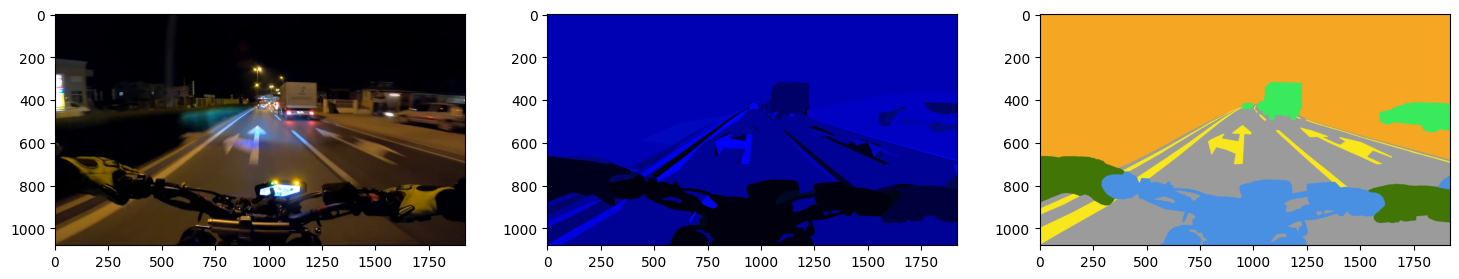

In [9]:
# fug_data

import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array

fig,axs = plt.subplots(1,3,figsize=(18,10))
axs[0].imshow(load_img(org_data[2]))
axs[1].imshow(load_img(sav_data[2]))
axs[2].imshow(load_img(fug_data[2]))

In [10]:
# img_to_array(load_img(sav_data[2]))
img = img_to_array(load_img(fug_data[2], color_mode="grayscale"))
img.shape

(1080, 1920, 1)

In [83]:
img_to_array(load_img(sav_data[2]))[35][1200]

array([  0.,   1., 179.], dtype=float32)

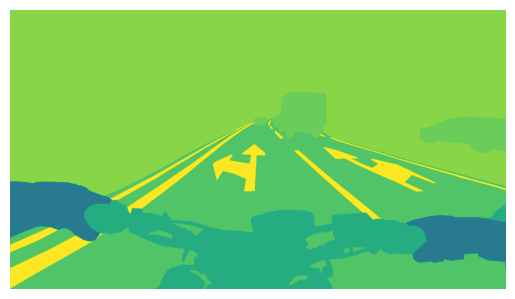

In [84]:
#이건 미정
def display_target(target_array):
    normalized_array = (target_array.astype("uint8"))
    plt.axis("off")
    plt.imshow(normalized_array[:, :, 0])

img = img_to_array(load_img(fug_data[2], color_mode="grayscale"))
display_target(img)

In [29]:
import numpy as np
import random

#u-net구조 변경을 위한 resize
img_size = (512, 512)
num_imgs = len(org_data)

random.Random(1337).shuffle(org_data)
random.Random(1337).shuffle(fug_data)

def path_to_input_image(path):
    return img_to_array(load_img(path, target_size=img_size))

def path_to_target(path):
    img = img_to_array(
        load_img(path, target_size=img_size, color_mode="grayscale"))
    img = img.astype("uint8")
    return img

input_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype="float32")
targets = np.zeros((num_imgs,) + img_size + (1,), dtype="uint8")
for i in range(num_imgs):
    input_imgs[i] = path_to_input_image(org_data[i])
    targets[i] = path_to_target(fug_data[i])

# val sample은 40개로 지정
num_val_samples = 40
train_input_imgs = input_imgs[:-num_val_samples]
train_targets = targets[:-num_val_samples]
val_input_imgs = input_imgs[-num_val_samples:]
val_targets = targets[-num_val_samples:]

In [66]:
len(img_to_array(load_img(sav_data[2]))[0][0])
img_to_array(load_img(sav_data[2]))[0][1]
len(img_to_array(load_img(sav_data[2])))

1080

In [60]:
len(sav_data)

200

![스크린샷 2023-10-30 오후 12.25.45.png](https://miro.medium.com/v2/resize:fit:720/format:webp/1*8T3P2kenhju8dNXgRPVyfg.png)

In [19]:
""" Conv Block """
class ConvBlock(tf.keras.layers.Layer):
    def __init__(self, n_filters):
        super(ConvBlock, self).__init__()

        self.conv1 = Conv2D(n_filters, 3, padding='same')
        self.conv2 = Conv2D(n_filters, 3, padding='same')

        self.bn1 = BatchNormalization()
        self.bn2 = BatchNormalization()

        self.activation = Activation('relu')

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.activation(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.activation(x)

        return x

In [20]:
""" Encoder Block """
class EncoderBlock(tf.keras.layers.Layer):
    def __init__(self, n_filters):
        super(EncoderBlock, self).__init__()

        self.conv_blk = ConvBlock(n_filters)
        self.pool = MaxPooling2D((2,2))

    def call(self, inputs):
        x = self.conv_blk(inputs)
        p = self.pool(x)
        return x, p

In [21]:
""" Decoder Block """
class DecoderBlock(tf.keras.layers.Layer):
    def __init__(self, n_filters):
        super(DecoderBlock, self).__init__()

        self.up = Conv2DTranspose(n_filters, (2,2), strides=2, padding='same')
        self.conv_blk = ConvBlock(n_filters)

    def call(self, inputs, skip):
        x = self.up(inputs)
        x = Concatenate()([x, skip])
        x = self.conv_blk(x)

        return x

In [69]:
""" U-Net Model """
class UNET(tf.keras.Model):
    def __init__(self, n_classes):
        super(UNET, self).__init__()

        # Encoder
        self.e1 = EncoderBlock(16)
        self.e2 = EncoderBlock(32)
        self.e3 = EncoderBlock(48)
        self.e4 = EncoderBlock(64)

        # Bridge
        self.b = ConvBlock(128)

        # Decoder
        self.d1 = DecoderBlock(64)
        self.d2 = DecoderBlock(48)
        self.d3 = DecoderBlock(32)
        self.d4 = DecoderBlock(16)

        # Outputs
        if n_classes == 6:
            activation = 'sigmoid'
        else:
            activation = 'softmax'

        self.outputs = Conv2D(n_classes, 1, padding='same', activation=activation)

    def call(self, inputs):
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)

        b = self.b(p4)

        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)

        outputs = self.outputs(d4)

        return outputs

In [70]:
n_classes = 1
unet = UNET(n_classes)

unet.build(input_shape=(None, 512, 512, 3)) # (batch, H, W, C)
unet.summary()

# (1080, 1920, 1)

Model: "unet_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_block_28 (EncoderB  multiple                  2896      
 lock)                                                           
                                                                 
 encoder_block_29 (EncoderB  multiple                  14144     
 lock)                                                           
                                                                 
 encoder_block_30 (EncoderB  multiple                  35040     
 lock)                                                           
                                                                 
 encoder_block_31 (EncoderB  multiple                  65152     
 lock)                                                           
                                                                 
 conv_block_67 (ConvBlock)   multiple                  22246

In [71]:
lr = 1e-4
unet.compile(loss=tf.keras.losses.BinaryCrossentropy(),
             optimizer=tf.keras.optimizers.Adam(lr),
             metrics=['accuracy'])

In [72]:
epochs = 3
history = unet.fit( train_input_imgs, train_targets, epochs=epochs, batch_size=4, shuffle=True, validation_data=(val_input_imgs,val_targets), verbose=2)


# model.fit(x_train, y_train, epochs=100, batch_size=1, validation_data=(x_val, y_val))
# train_input_imgs = input_imgs[:-num_val_samples]
# train_targets = targets[:-num_val_samples]
# val_input_imgs = input_imgs[-num_val_samples:]
# val_targets = targets[-num_val_samples:]

Epoch 1/3
40/40 - 34s - loss: 37.5872 - accuracy: 3.9101e-06 - val_loss: 20.9634 - val_accuracy: 0.0000e+00 - 34s/epoch - 862ms/step
Epoch 2/3
40/40 - 6s - loss: -3.7078e+00 - accuracy: 2.3603e-06 - val_loss: -7.3790e+00 - val_accuracy: 0.0000e+00 - 6s/epoch - 155ms/step
Epoch 3/3
40/40 - 6s - loss: -3.5733e+01 - accuracy: 1.4544e-06 - val_loss: -2.4011e+01 - val_accuracy: 0.0000e+00 - 6s/epoch - 151ms/step


In [ ]:
input_dir = "/content/drive/MyDrive/아이펠/data/Motorcycle Night Ride/www.acmeai.tech ODataset 1 - Motorcycle Night Ride Dataset/images"
class_count = 6

In [49]:
uniques = np.empty((0,3))
for j, name in enumerate(np.arange(50)):
    # print(f'Extracting unique classes from {name}')
    label = ""
    try:
        label = load_img(f"{image_path}/Screenshot ({name+309}).png___fuse.png")
    except:
        continue
        label_arr = img_to_array(label)
    label_reshaped = tf.reshape(label_arr, [-1, 3]).numpy()
    uniques = np.append(uniques, np.unique(label_reshaped, axis=0), axis=0)

np.unique(uniques, axis=0).shape

uniques = np.unique(uniques, axis=0)
categories = uniques.tolist()
cat_list = np.eye(len(categories))

In [52]:
uniques

array([], shape=(0, 3), dtype=float64)